In [1]:
from realkd.rules import RuleBoostingEstimator, XGBRuleEstimator, logistic_loss
from realkd.search import search_methods
from numba import njit, parallel_chunksize
import pandas as pd
import sortednp as snp
import doctest
from realkd.search import GreedySearch
import matplotlib.pyplot as plt

from collections import defaultdict, deque
from sortedcontainers import SortedSet
from math import inf
from heapq import heappop, heappush
from numpy import array
from bitarray import bitarray
import collections.abc
from numba.typed import List
from math import inf
from numpy import arange, argsort, array, cumsum, exp, full_like, log2, stack, zeros, zeros_like
from pandas import qcut, Series
import time
from sklearn.base import BaseEstimator, clone

from realkd.search import Conjunction, Context, KeyValueProposition, Constraint, NumbaGreedySearch
from bitarray.util import subset
import numpy as np
import pandas as pd

from realkd.logic import Conjunction, Constraint, KeyValueProposition, TabulatedProposition

In [2]:
RNG = np.random.default_rng(seed=0)

def rand_array(size, alpha=0.2):
    n, k = size
    d = np.arange(n*k)
    RNG.shuffle(d)
    d = (d < alpha*len(d)).astype(int)
    return d.reshape(n, k)
# n = number of columns
# m = number of rows
ns = np.arange(50, 501, 50)
ms = np.arange(500, 1101, 200)

alpha = 0.5

d = {}
for m in ms:
    for n in ns:
        X = rand_array((m, n), alpha=alpha)
        true_weights = RNG.random(n) * 10
        y = X @ true_weights + RNG.random(m)
        y = np.sign(y - y.mean())
        dfX = pd.DataFrame(data=X, index=None, columns=[f'x{i}' for i in range(X.shape[1])])
        dfy = pd.Series(data=y)
        d[(m, n)] = (dfX, dfy)

In [3]:
def get_ghregn(X, y):
    """
    This would be part of the objective e.g GradientBoostingObjective
    """
    # The following is only ONE example of this class of objective function, it would be different for
    # different X, y, losses, regs and predictions.
    loss = logistic_loss
    reg = 1.0
    predictions = zeros_like(y)
    g = array(loss.g(y, predictions))
    h = array(loss.h(y, predictions))
    r = g / h
    order = argsort(r)[::-1]
    g = g[order]
    h = h[order]
    n = y.shape[0]

    def objective_function(ext):
        if len(ext) == 0:
            return -inf
        g_q = g[ext]
        h_q = h[ext]
        return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))

    return g, h, reg, objective_function

In [4]:
def run_search_numba(data, context):
    ctx, g, h, reg, obj_fn = context
    search = NumbaGreedySearch(ctx=ctx, bdn=None, g=g, h=h, reg=reg)
    search.run()

def run_search_base(data, context):
    ctx, g, h, reg, obj_fn = context
    search = GreedySearch(ctx=ctx, obj=obj_fn, bdn=None)
    search.run()


t_numba = {}
t_base = {}

ms_to_plot = ms
ns_to_plot = ns

pre_made_ctx = {}

for m in ms_to_plot:
    data = d[(m, ns[0])]
    ctx = Context.from_df(data[0])
    g, h, reg, obj_fn = get_ghregn(data[0], data[1])
    pre_made_ctx[(m, ns[0])] = ctx, g, h, reg, obj_fn

for n in ns_to_plot:
    data = d[(ms[0], n)]
    ctx = Context.from_df(data[0])
    g, h, reg, obj_fn = get_ghregn(data[0], data[1])
    pre_made_ctx[(ms[0], n)] = ctx, g, h, reg, obj_fn


# Dry runs to compile numba code
run_search_numba(d[(ms[0], ns[0])], pre_made_ctx[(ms[0], ns[0])])
run_search_base(d[(ms[0], ns[0])], pre_made_ctx[(ms[0], ns[0])])

for m in ms_to_plot:
    t_numba[(m, ns[0])] = %timeit -o run_search_numba(d[(m, ns[0])], pre_made_ctx[(m, ns[0])])
    t_base[(m, ns[0])] = %timeit -o run_search_base(d[(m, ns[0])], pre_made_ctx[(m, ns[0])])

for n in ns_to_plot:
    t_numba[(ms[0], n)] = %timeit -o run_search_numba(d[(ms[0], n)], pre_made_ctx[(ms[0], n)])
    t_base[(ms[0], n)] = %timeit -o run_search_base(d[(ms[0], n)], pre_made_ctx[(ms[0], n)])

1.97 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.99 ms ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.58 ms ± 8.93 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.03 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.26 ms ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.53 ms ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.84 ms ± 76.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.11 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.85 ms ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.98 ms ± 30.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.76 ms ± 24.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.92 ms ± 33.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.84 ms ± 38 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.6 ms ± 52.4 µs per loop (mean ± std. dev. of 7 runs, 100 loop

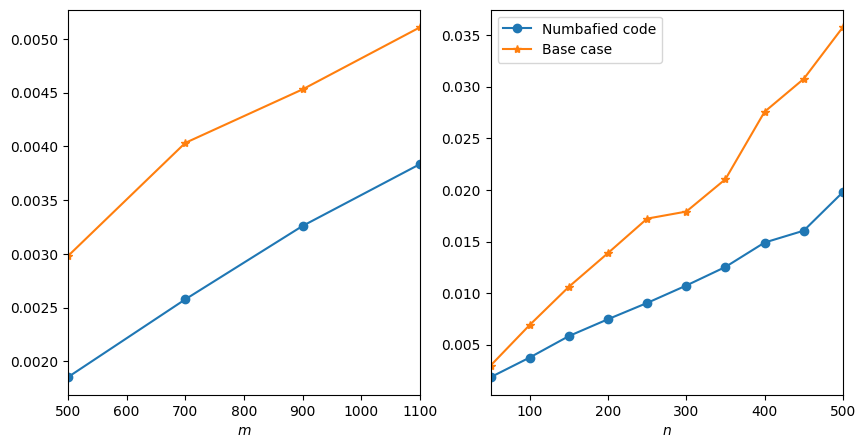

In [5]:
plt.subplots(1, 2, figsize=(10, 5))

t_numba_mean = [t_numba[(m, ns[0])].average for m in ms_to_plot]
t_numba_std = [t_numba[(m, ns[0])].stdev for m in ms_to_plot]
t_base_mean = [t_base[(m, ns[0])].average for m in ms_to_plot]
t_base_std = [t_base[(m, ns[0])].stdev for m in ms_to_plot]

plt.subplot(1, 2, 1)
plt.plot(ms_to_plot, t_numba_mean, marker='o')
plt.plot(ms_to_plot, t_base_mean, marker='*')
plt.xlim(ms_to_plot[0], ms_to_plot[-1])
plt.xlabel('$m$')

t_numba_mean = [t_numba[(ms[0], n)].average for n in ns_to_plot]
t_numba_std = [t_numba[(ms[0], n)].stdev for n in ns_to_plot]
t_base_mean = [t_base[(ms[0], n)].average for n in ns_to_plot]
t_base_std = [t_base[(ms[0], n)].stdev for n in ns_to_plot]

plt.subplot(1, 2, 2)
plt.plot(ns_to_plot, t_numba_mean, marker='o', label='Numbafied code')
plt.plot(ns_to_plot, t_base_mean, marker='*', label='Base case')
plt.xlim(ns_to_plot[0], ns_to_plot[-1])
plt.xlabel('$n$')
plt.legend()

plt.show()